In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm

from frechet_fda.config import SRC
from frechet_fda.tools.data_generation_tools import (
    gen_params_scenario_one,
    gen_params_scenario_two,
    gen_truncnorm_pdf_points,
    make_estimated_pdf,
    make_truncnorm_pdf,
)
from frechet_fda.tools.function_tools import (
    frechet_mean,
    get_optimal_range,
    inverse_log_qd_transform,
    log_qd_transform,
    make_function_objects,
    mean_func,
)
from frechet_fda.tools.fda_tools import (
    compute_mean_and_centered_data,
    compute_cov_function,
    compute_principal_components,
    gen_qdtransformation_pcs,
    k_optimal,
    karhunen_loeve,
    mode_of_variation,
    total_frechet_variance,
)

In [2]:
# Set parameters
n = 200
grid_size = 2000
trunc = 3
mus, sigmas = gen_params_scenario_one(n, seed=None)
# Sort sigmas just for inspection reasons
sigmas.sort()

In [3]:
# Generate pdfs within truncation points
pdfs = make_truncnorm_pdf(
    -trunc, trunc, mus, sigmas, grid_size=grid_size, warn_irregular_densities=False
)
# Make lists of Function class objects
my_pdfs = make_function_objects(pdfs)
my_cdfs = [pdf.integrate() for pdf in my_pdfs]
my_qfs = [cdf.invert() for cdf in my_cdfs]
my_qdfs = [qf.differentiate() for qf in my_qfs]
# For numerical correction: shorten the range for smaller sigmas to get rid of
# numerical artifacts when computing integrals, derivatives and means later
new_ranges = get_optimal_range(my_pdfs)
# Generate pdfs again, this time within individual ranges
pdfs2 = [
    make_truncnorm_pdf(
        new_ranges[i][0],
        new_ranges[i][1],
        mus[i],
        sigmas[i],
        grid_size=grid_size,
        warn_irregular_densities=False,
    )[0]
    for i in range(n)
]

C:\Coding\frechet_fda\src\frechet_fda\tools\numerics_tools.py:62: RuntimeWarning: divide by zero encountered in divide
  d_y[:-1] = np.diff(y_vals) / np.diff(d_x)


In [4]:
# Generate all the distribution objects
new_pdfs = make_function_objects(pdfs2)
new_cdfs = [pdf.integrate() for pdf in new_pdfs]
new_qfs = [cdf.invert() for cdf in new_cdfs]
new_qdfs = [qf.differentiate() for qf in new_qfs]

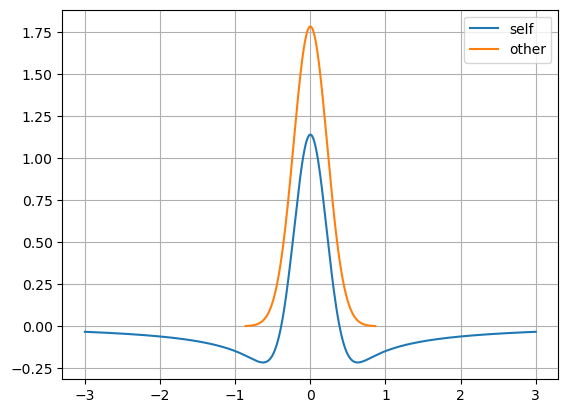

In [5]:
# Compute centered data, just to see whether it works
# One can clearly see how inappropriate it is to apply fda methods on densities
pdf_of_interest = sigmas.argmin()
mean_pdf, centered_pdfs = compute_mean_and_centered_data(new_pdfs)
centered_pdfs[pdf_of_interest].compare(new_pdfs[pdf_of_interest])

In [6]:
covariance_function = compute_cov_function(centered_pdfs)

In [7]:
eigenvalues, eigenfunctions = compute_principal_components(
    centered_pdfs[0].x,
    covariance_function,
)

## Transformation FPCA

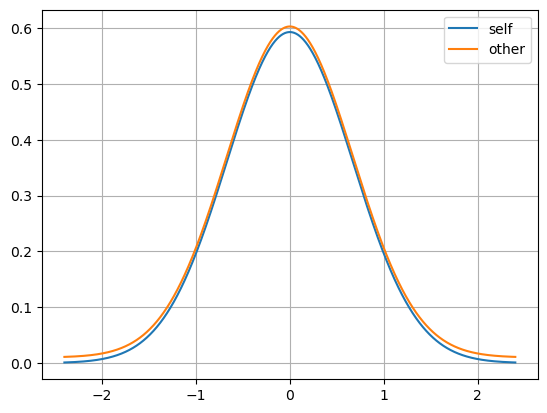

In [8]:
# Transform pdf sample, and test whether inverse works. Manually add some constant
# to help distinguish the curves
qf_of_interest = 80
log_qdfs = log_qd_transform(new_pdfs)
inverse_log_qdfs = inverse_log_qd_transform(log_qdfs)
inverse_log_qdfs[qf_of_interest].compare(new_pdfs[qf_of_interest] + 0.01)

In [9]:
# Compute transformation FPCA objects
pcs_to_compute = 15
(
    mean_log_qdfs,
    eigenvalues_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
) = gen_qdtransformation_pcs(log_qdfs, k=pcs_to_compute)

In [10]:
eigenvalues_log_qdfs[0], eigenvalues_log_qdfs[1], eigenvalues_log_qdfs[2]

(0.43599334821200064, 0.021599764855535813, 0.0009398419638676245)

In [11]:
# Karhunen-Loève decomposition of transforms
truncation_k = 2
truncated_representations_transforms = karhunen_loeve(
    mean_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
    K=truncation_k,
)

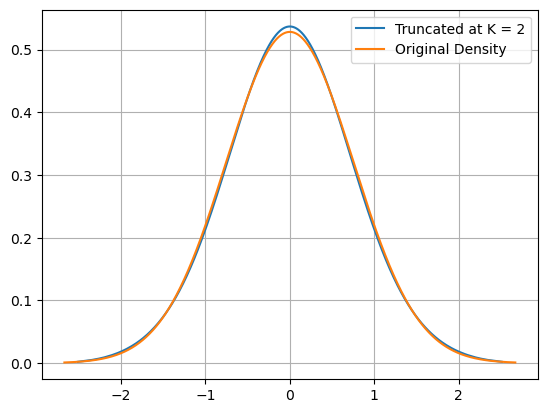

In [12]:
# Transform to density space. Compare truncated representation against real density
pdf_of_interest = 90
truncated_representations = inverse_log_qd_transform(
    truncated_representations_transforms,
)
truncated_representations[pdf_of_interest].compare(
    new_pdfs[pdf_of_interest],
    label_self=f"Truncated at K = {truncation_k}",
    label_other="Original Density",
)

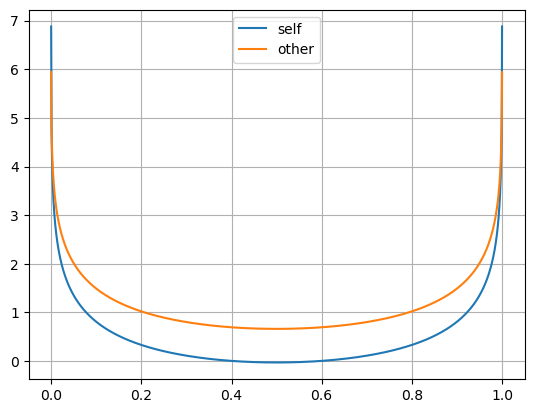

In [13]:
# Look at modes of variance of transformed functions
variation_modes_transforms = [
    mode_of_variation(mean_log_qdfs, eigval, eigfunc, alpha=1)
    for eigval, eigfunc
    in zip(eigenvalues_log_qdfs, eigenfunctions_log_qdfs, strict=True)
]
variation_modes_transforms[0].compare(variation_modes_transforms[1])

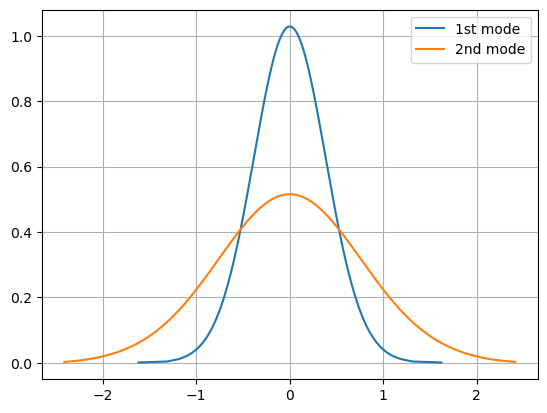

In [14]:
# Translate modes of variation to density space, compare first two modes
variation_modes = inverse_log_qd_transform(variation_modes_transforms)
variation_modes[0].compare(
    variation_modes[1],
    label_self="1st mode",
    label_other="2nd mode",
)

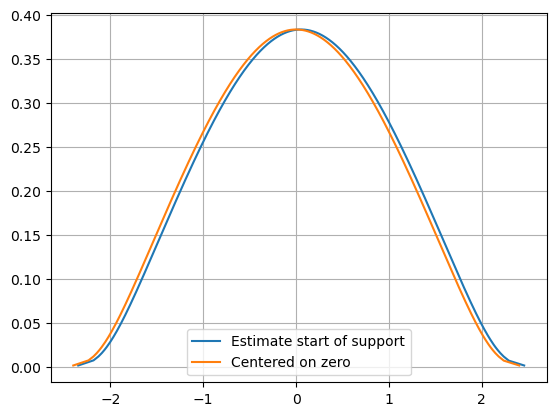

In [15]:
# Compute Fréchet mean
f_mean = frechet_mean(new_pdfs, centered_on_zero = False)
f_mean.compare(frechet_mean(new_pdfs, centered_on_zero = True), label_self="Estimate start of support", label_other= "Centered on zero")

In [16]:
# Compute Fréchet variance
total_variance = total_frechet_variance(f_mean, new_pdfs)

In [17]:
# Try function that finds optimal trunc representation
optimal_k, fraction_explained, truncated_representations = k_optimal(
    0.8,
    total_variance,
    new_pdfs,
    mean_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
)
optimal_k, fraction_explained

(1, 0.9877121005759031)

# Simulation

In [18]:
# Number of simulations
m = 500
# Number of samples of densities to generate
sample_sizes = [50, 100, 200]
# Number of sample points to generate from each density for density estimation step
points_number = 100
# Bandwidth choice for density estimation
bandwidth_choice = 0.2
# Fineness of grids to evaluate functions
grid_size = 1000
# Where to truncate normal distribution
trunc = 3
# Choose how many FPCS to compute. Maximum: grid_size
how_many_fpcs = 10
# How much variance to be explained for cutoff in KH-representation
threshold_variance_explained = 0.9
# Whether to compute Wasserstein-Fréchet means artifically centered on zero
centered_on_zero = False
# Initialize arrays to store Fréchet and cross sectional means
stored_f_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_f_means_denstimation = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means_denstimation = np.empty((m, len(sample_sizes)), dtype="object")

In [19]:
total_iterations = m * len(sample_sizes)  # Total iterations
progress_bar = tqdm(total=total_iterations, desc="Simulation")
for i in range(m):
    # Try different sample sizes
    for j, n in enumerate(sample_sizes):
        # j index only used for storing Fréchet means below!
        # Set parameters
        seed_num = int(str(i) + str(j))  # unique seed in each simulation run
        mus, sigmas = gen_params_scenario_one(n, seed=seed_num)
        # Sort sigmas just for inspection reasons
        sigmas.sort()

        # Generate pdfs within truncation points
        pdfs = make_truncnorm_pdf(
            -trunc,
            trunc,
            mus,
            sigmas,
            grid_size=grid_size,
            warn_irregular_densities=False,
        )
        # Make Function class objects
        my_pdfs = make_function_objects(pdfs)

        # For numerical correction: shorten the range for smaller sigmas to get rid of
        # numerical artifacts when computing integrals, derivatives and means later
        new_ranges = get_optimal_range(my_pdfs)
        # Generate pdfs again, this time within individual ranges
        pdfs2 = [
            make_truncnorm_pdf(
                new_ranges[i][0],
                new_ranges[i][1],
                mus[i],
                sigmas[i],
                grid_size=grid_size,
                warn_irregular_densities=False,
            )[0]
            for i in range(n)
        ]

        # Generate numerically stable objects
        new_pdfs = make_function_objects(pdfs2)

        # Compute Fréchet mean
        stored_f_means[i, j] = frechet_mean(new_pdfs, centered_on_zero=centered_on_zero)
        stored_cs_means[i, j] = mean_func(new_pdfs)

        # Compute Fréchet variance
        total_variance = total_frechet_variance(stored_f_means[i, j], new_pdfs)

        # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdfs)
        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs, k=how_many_fpcs)

        # Try function that finds optimal trunc representation. Threshold: explain
        # at least threshold_variance_explained
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            threshold_variance_explained,
            total_variance,
            new_pdfs,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        )

        ### And now again with additional density estimation step!
        which_kernel = "std_normal"
        sample_points = gen_truncnorm_pdf_points(
            -trunc, trunc, mus, sigmas, points_number
        )
        pdf_hats = make_estimated_pdf(
            sample_points=sample_points,
            a=-trunc * np.ones(n),
            b=trunc * np.ones(n),
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=bandwidth_choice,
        )

        new_ranges = get_optimal_range(pdf_hats)
        # Generate numerically stable objects, within individual ranges
        new_pdf_hats = make_estimated_pdf(
            sample_points=sample_points,
            a=new_ranges[:, 0],
            b=new_ranges[:, 1],
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=bandwidth_choice,
        )

        # Compute Fréchet mean
        stored_f_means_denstimation[i, j] = frechet_mean(
            new_pdf_hats, centered_on_zero=centered_on_zero
        )
        stored_cs_means_denstimation[i, j] = mean_func(new_pdf_hats)

        # Compute Fréchet variance
        total_variance = total_frechet_variance(
            stored_f_means_denstimation[i, j], new_pdf_hats,
        )

        # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdf_hats)

        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs, k=how_many_fpcs)

        # Try function that finds optimal trunc representation. Threshold: explain
        # at least threshold_variance_explained
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            threshold_variance_explained,
            total_variance,
            new_pdf_hats,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        )

        # Print progress of simulation
        progress_bar.update()
progress_bar.close()

Simulation:   0%|          | 0/1500 [00:00<?, ?it/s]

Simulation:   0%|          | 4/1500 [00:09<1:01:11,  2.45s/it]

KeyboardInterrupt: 

In [ ]:
if m > 100:
    # Create a dictionary to hold all arrays
    data_dict = {
        "stored_means_frechet": stored_f_means,
        "stored_means_cs": stored_cs_means,
        "stored_means_frechet_denstimation": stored_f_means_denstimation,
        "stored_means_cs_denstimation": stored_cs_means_denstimation,
    }

    # Save the dictionary using pickle
    file_path_pickle = SRC / "sim_results" / "stored_means_arrays.pkl"

    with open(file_path_pickle, "wb") as handle:
        pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Calculate true center of distribution for plotting against estimates
std_normal = make_truncnorm_pdf(-trunc, trunc, 0, 1, grid_size=grid_size)[0]

C:\Coding\frechet_fda\src\frechet_fda\tools\data_generation_tools.py:258: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.4175481690248404e-05
 In position: 0
 Performing normalization...
  warnings.warn(


In [ ]:
# Calculate Fréchet means of Fréchet means over all simulations
mean_of_f_means50 = frechet_mean(stored_f_means[:, 0], centered_on_zero=centered_on_zero)
mean_of_f_means100 = frechet_mean(stored_f_means[:, 1], centered_on_zero=centered_on_zero)
mean_of_f_means200 = frechet_mean(stored_f_means[:, 2], centered_on_zero=centered_on_zero)
mean_of_cs_means50 = frechet_mean(stored_cs_means[:, 0], centered_on_zero=centered_on_zero)
mean_of_cs_means100 = frechet_mean(stored_cs_means[:, 1], centered_on_zero=centered_on_zero)
mean_of_cs_means200 = frechet_mean(stored_cs_means[:, 2], centered_on_zero=centered_on_zero)
mean_of_f_means50_denstimation = frechet_mean(stored_f_means_denstimation[:, 0], centered_on_zero=centered_on_zero)
mean_of_f_means100_denstimation = frechet_mean(stored_f_means_denstimation[:, 1], centered_on_zero=centered_on_zero)
mean_of_f_means200_denstimation = frechet_mean(stored_f_means_denstimation[:, 2], centered_on_zero=centered_on_zero)
mean_of_cs_means50_denstimation = frechet_mean(stored_cs_means_denstimation[:, 0], centered_on_zero=centered_on_zero)
mean_of_cs_means100_denstimation = frechet_mean(stored_cs_means_denstimation[:, 1], centered_on_zero=centered_on_zero)
mean_of_cs_means200_denstimation = frechet_mean(stored_cs_means_denstimation[:, 2], centered_on_zero=centered_on_zero)

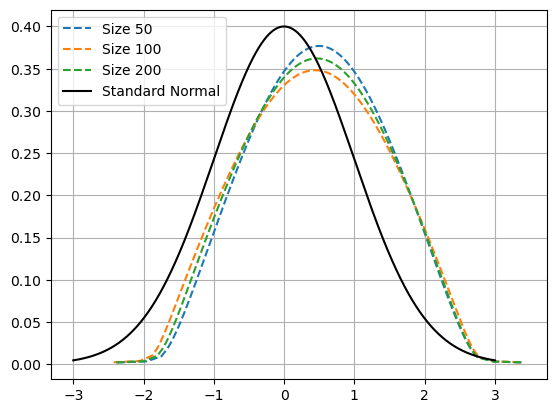

In [ ]:
# Plot Fréchet means of different sample sizes against true center
fig, ax = plt.subplots()
ax.plot(mean_of_f_means50.x, mean_of_f_means50.y, label="Size 50", linestyle="--")
ax.plot(mean_of_f_means100.x, mean_of_f_means100.y, label="Size 100", linestyle="--")
ax.plot(mean_of_f_means200.x, mean_of_f_means200.y, label="Size 200", linestyle="--")
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="Black")
plt.legend()
plt.grid()
plt.show()

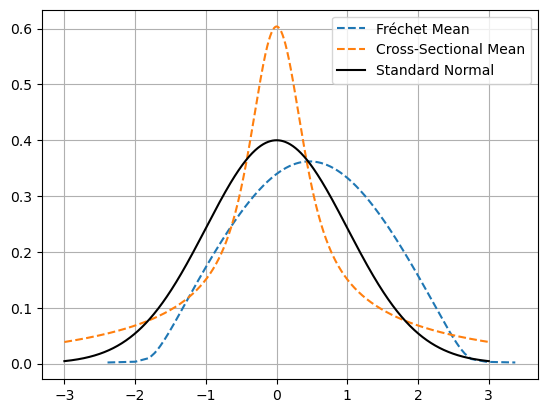

In [ ]:
# Plot Fréchet mean vs cross-sectional mean and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x, mean_of_f_means200.y, label="Fréchet Mean", linestyle="--",
)
ax.plot(
    mean_of_cs_means200.x,
    mean_of_cs_means200.y,
    label="Cross-Sectional Mean",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
plt.show()

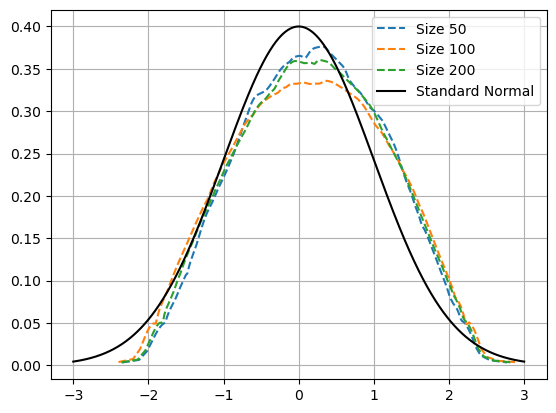

In [ ]:
# Plot Fréchet means from estimated densities and of different sample sizes against true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means50_denstimation.x,
    mean_of_f_means50_denstimation.y,
    label="Size 50",
    linestyle="--",
)
ax.plot(
    mean_of_f_means100_denstimation.x,
    mean_of_f_means100_denstimation.y,
    label="Size 100",
    linestyle="--",
)
ax.plot(
    mean_of_f_means200_denstimation.x,
    mean_of_f_means200_denstimation.y,
    label="Size 200",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="Black")
plt.legend()
plt.grid()
plt.show()

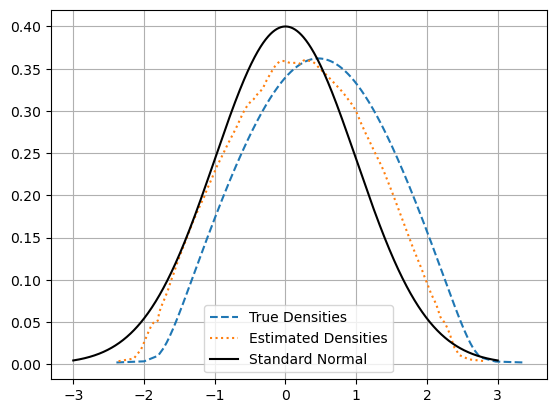

In [ ]:
# Plot Fréchet mean with true densities against estimated densities and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x,
    mean_of_f_means200.y,
    label="True Densities",
    linestyle="--",
)
ax.plot(
    mean_of_f_means200_denstimation.x,
    mean_of_f_means200_denstimation.y,
    label="Estimated Densities",
    linestyle="dotted",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
plt.show()

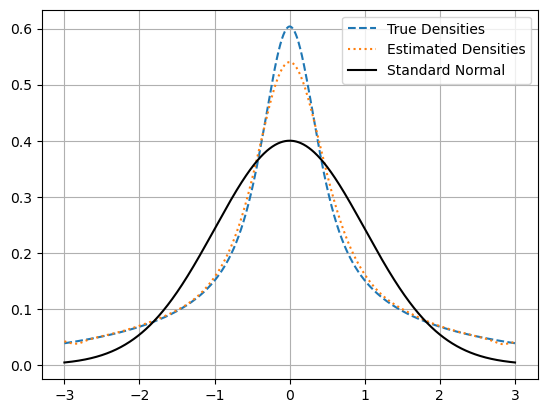

In [ ]:
# Plot cross-sectional mean with true densities against estimated densities and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_cs_means200.x,
    mean_of_cs_means200.y,
    label="True Densities",
    linestyle="--",
)
ax.plot(
    mean_of_cs_means200_denstimation.x,
    mean_of_cs_means200_denstimation.y,
    label="Estimated Densities",
    linestyle="dotted",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
plt.show()

## Sandbox: Implement density estimation step

In [ ]:
n = 200
grid_size = 1000
trunc = 3
bandwitherino = 1.2
mus, sigmas = gen_params_scenario_one(n, seed=123456)
sigmas.sort()

In [ ]:
sample_points = gen_truncnorm_pdf_points(-trunc, trunc, mus, sigmas, 100)
pdf_hats = make_estimated_pdf(
    sample_points=sample_points,
    a=-trunc * np.ones(n),
    b=trunc * np.ones(n),
    kern="epanechnikov",
    grid_size=grid_size,
    bandwidth=bandwitherino,
)
new_ranges = get_optimal_range(pdf_hats)
# Generate numerically stable objects, within individual ranges
new_pdf_hats = make_estimated_pdf(
    sample_points=sample_points,
    a=new_ranges[:, 0],
    b=new_ranges[:, 1],
    kern="epanechnikov",
    grid_size=grid_size,
    bandwidth=bandwitherino,
)

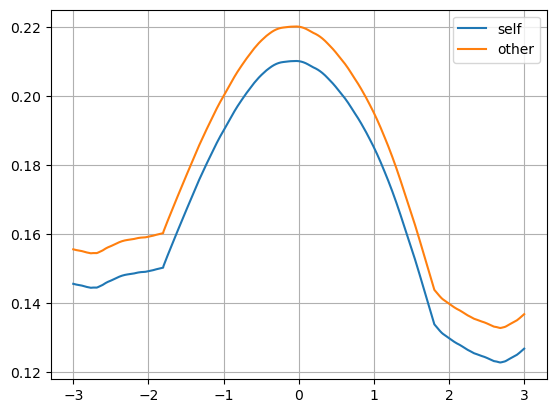

In [ ]:
interesting_pdf = 150
pdf_hats[interesting_pdf].compare(new_pdf_hats[interesting_pdf] + 0.01)